# GMM n EM

* Gaussina mixture models
* Expectation Maximization EM optimization algorithm

https://github.com/mcdickenson/em-gaussian/blob/master/em-gaussian.py

In [2]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import norm
from sys import maxsize 

maxint = maxsize

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

,label,x,y
0,1,0.785224,5.027652
1,1,1.719339,3.728175
2,1,0.217693,3.287058
3,1,0.305673,3.615690
4,1,0.113982,4.412576


,label,x,y
195,2,5.535699,0.237943
196,2,6.507550,0.827544
197,2,7.832236,2.007593
198,2,2.095094,-0.846976
199,2,6.630515,2.028852


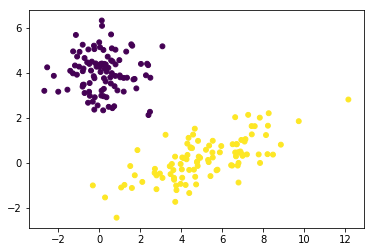

In [13]:

### Setup
# set random seed
rand.seed(42)

# 2 clusters
# not that both covariance matrices are diagonal
mu1 = [0, 4]
sig1 = [ [1, 0], [0, 1] ]

mu2 = [5, 0]
sig2 = [ [4, 1.3], [1.3, 1] ]

# generate samples
x1, y1 = np.random.multivariate_normal(mu1, sig1, 100).T
x2, y2 = np.random.multivariate_normal(mu2, sig2, 100).T

xs = np.concatenate((x1, x2))
ys = np.concatenate((y1, y2))
labels = ([1] * 100) + ([2] * 100)

data = {'x': xs, 'y': ys, 'label': labels}
df = pd.DataFrame(data=data)

# inspect the data
df.head()
df.tail()

fig = plt.figure()
plt.scatter(data['x'], data['y'], 24, c=data['label'])
#fig.savefig("true-values.png")

In [14]:
df.to_csv('bi_dimensional_n_bi_modal_data.csv', index=False)

### Expectation-maximization

In [34]:
# initial guesses - intentionally bad
guess = { 'mu1': [1,1],
          'sig1': [ [1, 0], [0, 1.1] ],
          'mu2': [4,4],
          'sig2': [ [0.8, 0], [0, 0.9] ],
          'lambda': [0.4, 0.6]
        }

In [30]:
# probability that a point came from a Guassian with given parameters
# note that the covariance must be diagonal for this to work
# prob = N(lam,mu,sig|x)
# x is multimensional Point
def prob(x, mu, sig, lam):
    p = lam
    for i in range(len(x)):
        p *= norm.pdf(x[i], mu[i], sig[i][i])
    return p


# assign every data point to its most likely cluster
def expectation(dataFrame, parameters):
    
    for i in range(dataFrame.shape[0]):

        x = dataFrame['x'][i]
        y = dataFrame['y'][i]
    
        print(list(parameters['mu1']))
        print(list(parameters['sig1']))
        p_cluster1 = prob([x, y], list(parameters['mu1']), list(parameters['sig1']), parameters['lambda'][0] )
        p_cluster2 = prob([x, y], list(parameters['mu2']), list(parameters['sig2']), parameters['lambda'][1] )

        if p_cluster1 > p_cluster2:
            dataFrame['label'][i] = 1
        else:
            dataFrame['label'][i] = 2
            
    return dataFrame

## Maximization

In [31]:
# update estimates of lambda, mu and sigma
def maximization(dataFrame, parameters):
    
    points_assigned_to_cluster1 = dataFrame[dataFrame['label'] == 1]
    points_assigned_to_cluster2 = dataFrame[dataFrame['label'] == 2]
    
    percent_assigned_to_cluster1 = len(points_assigned_to_cluster1) / float(len(dataFrame))
    percent_assigned_to_cluster2 = 1 - percent_assigned_to_cluster1
    
    parameters['lambda'] = [percent_assigned_to_cluster1, percent_assigned_to_cluster2 ]
    
    parameters['mu1'] = [points_assigned_to_cluster1['x'].mean(), points_assigned_to_cluster1['y'].mean()]
    parameters['mu2'] = [points_assigned_to_cluster2['x'].mean(), points_assigned_to_cluster2['y'].mean()]
    
    parameters['sig1'] = [ [points_assigned_to_cluster1['x'].std(), 0 ], [ 0, points_assigned_to_cluster1['y'].std() ] ]
    parameters['sig2'] = [ [points_assigned_to_cluster2['x'].std(), 0 ], [ 0, points_assigned_to_cluster2['y'].std() ]
                         ]
    return parameters

# get the distance between points
# used for determining if params have converged
def distance(old_params, new_params):

    dist = 0
    
    for param in ['mu1', 'mu2']:
        for i in range(len(old_params)):
            dist += (old_params[param][i] - new_params[param][i]) ** 2

    return dist ** 0.5

### Fitting GMM

In [35]:
# loop until parameters converge
shift = maxint
epsilon = 0.01
iters = 0
df_copy = df.copy()
# randomly assign points to their initial clusters
df_copy['label'] = map(lambda x: x+1, np.random.choice(2, len(df)))
params = pd.DataFrame(guess)

df_copy.head(5)

params.head(5)

,label,x,y
0,<map object at 0x10bbe9940>,2.378563,3.974795
1,<map object at 0x10bbe9940>,-0.374676,5.898392
2,<map object at 0x10bbe9940>,0.671553,4.248700
3,<map object at 0x10bbe9940>,-1.992871,3.990668
4,<map object at 0x10bbe9940>,-2.269382,7.178136


,lambda,mu1,mu2,sig1,sig2
0,0.4,1,4,"[1, 0]","[0.8, 0]"
1,0.6,1,4,"[0, 1.1]","[0, 0.9]"


In [37]:
x = df_copy['x'][0]
y = df_copy['y'][0]

print('x n y')
print('{},{}'.format(x,y))

print('mu1')
params['mu1']
list(params['mu1'])

print('sigma1')
list(params['sig1'])
params['sig1']

print('lamda1')
params['lambda'][0]

p_cluster1 = prob([x, y], list(params['mu1']), list(params['sig1']), params['lambda'][0] )

print(prob)
p_cluster1

x n y
2.3785634351700478,3.9747948930738124
mu1


0    1
1    1
Name: mu1, dtype: int64

[1, 1]

sigma1


[[1, 0], [0, 1.1]]

0      [1, 0]
1    [0, 1.1]
Name: sig1, dtype: object

lamda1


0.4

<function prob at 0x1a173acf28>


0.0005776887472547243

/Users/leandro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/leandro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


iteration 1, shift 1.1790223254273429


iteration 2, shift 0.7028786287280147


iteration 3, shift 1.1326781941986228


iteration 4, shift 0.9652474823108527


iteration 5, shift 0.10494314642916869


iteration 6, shift 0.04943017989606146


iteration 7, shift 0.05086680363166582


iteration 8, shift 0.0


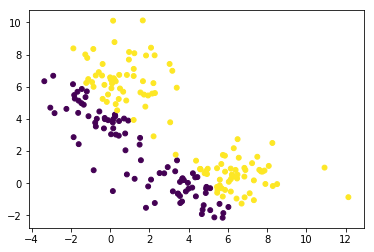

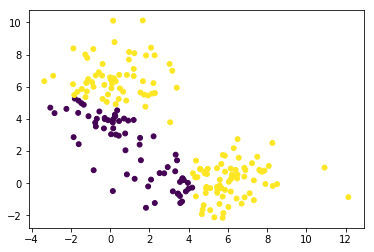

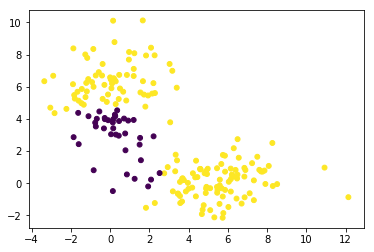

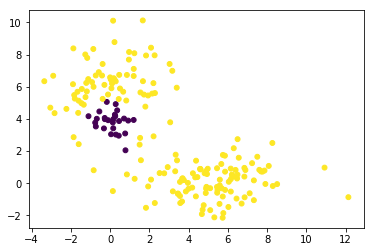

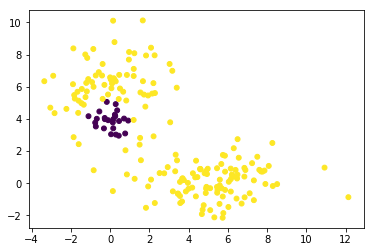

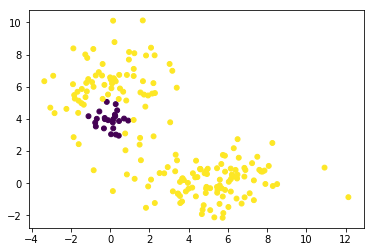

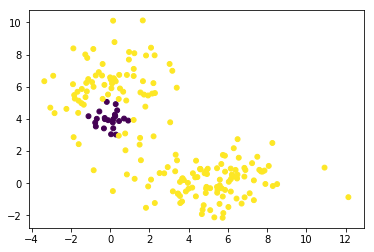

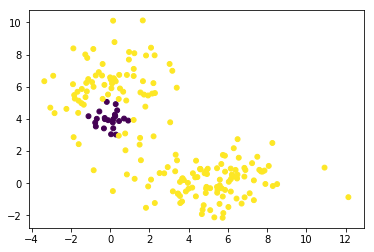

In [22]:
while shift > epsilon:
    iters += 1
    # E-step
    updated_labels = expectation(df_copy.copy(), params)

    # M-step
    updated_parameters = maximization(updated_labels, params.copy())

    # see if our estimates of mu have changed
    # could incorporate all params, or overall log-likelihood
    shift = distance(params, updated_parameters)

    # logging
    print("iteration {}, shift {}".format(iters, shift))

    # update labels and params for the next iteration
    df_copy = updated_labels
    params = updated_parameters

    fig = plt.figure()
    plt.scatter(df_copy['x'], df_copy['y'], 24, c=df_copy['label'])
    fig.savefig("iteration{}.png".format(iters))